## Visualizing the Bexar Data

To better understand potential features for future models, I visualized several of the variables. I started by plotting the criminally-linked properties on a map to determine if there was any geographic affiliation. I then visualized the differences between types of ownership. Next, I compared price per square foot across ownership types, foreign ownership, and owners who own multiple properties, among other variables. I then compared YoY price fluctuations between criminally-linked properties and the broader population of data. Lastly, I dropped several variables and plotted correlation.

In [453]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import json

sns.set_style('darkgrid')

import folium
from folium.plugins import HeatMap
from folium import plugins
from geopy import geocoders
from geopy.extra.rate_limiter import RateLimiter

In [454]:
# Load in data
prop_df = pd.read_hdf('../data/processed/bexar_processed.h5')

### Plot Properties on Map

In [456]:
# Pull out addresses and zip codes for criminally-linked properties
mapping_crim_df = prop_df[prop_df['crim_address'].notna()==True][['crim_address','situs_zip']].reset_index()

In [457]:
skip = 1
if skip == 0:
    # Use geopy to get coordinates of each address
    # Easy to hit the rate limit if run too frequently
    locator = geocoders.Nominatim(user_agent="property_mapping_project")
    geocode = RateLimiter(locator.geocode, min_delay_seconds=3)

    for i in range(len(mapping_crim_df['crim_address'])):

        address_to_try = mapping_crim_df.iloc[i,1]
        try:
            location = geocode(address_to_try, exactly_one=True)
            mapping_crim_df.iloc[i,3] = location.latitude
            mapping_crim_df.iloc[i,4] = location.longitude

        except Exception:
            print('No geocode found at', address_to_try)

            try:
                zip_code_to_try = mapping_crim_df.iloc[i,2]
                print('Trying zip code',zip_code_to_try)
                location_2 = geocode(zip_code_to_try)
                mapping_crim_df.iloc[i,3] = location_2.latitude
                mapping_crim_df.iloc[i,4] = location_2.longitude

            except Exception:
                print('No geocode found at',zip_code_to_try)

    data = [[row['latitude'],row['longitude']] for index, row in mapping_crim_df.dropna().iterrows()]

In [528]:
# Use folium to map each point
m = folium.Map(
    location=[29.513151, -98.497901],
    zoom_start=9.5
)

for i in data:
    folium.Marker(i).add_to(m)
    
display(m)
from IPython.core.display import HTML
HTML(m._repr_html_())

In [523]:
# Save as html
m.save("crim_prop_map.html")

### Geographic Concentration

The above map seems to indicate that these properties are geographically concentrated; grouping by neighborhood code and zip code may show similar.

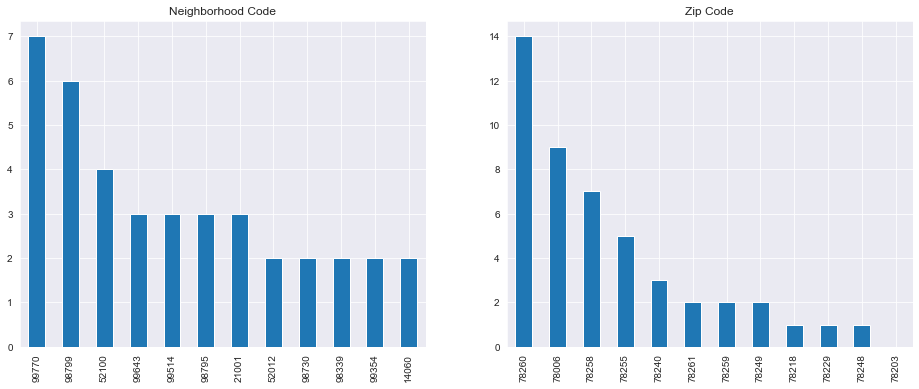

In [460]:
crim_sub_df = prop_df[prop_df.crim_prop==1]
groups = ['hood_cd','situs_zip']
titles = ['Neighborhood Code','Zip Code']

plots = len(groups)
fig, axes = plt.subplots((int(plots/2)),2,figsize=[16,6])

for ax, var, title in zip(axes.flat,groups,titles):
    crim_sub_df[str(var)].value_counts()[:12].plot(kind='bar',ax=ax,title=title)
plt.show()

These two figures do further indicate there is a geographic component to the properties labeled as criminally-linked.

### Distribution of Last Deed Transfer Date 

How many of the properties in the 2019 dataset have changed hands since 1990?

Only 8448 properties have had their deed transferred since 1990.


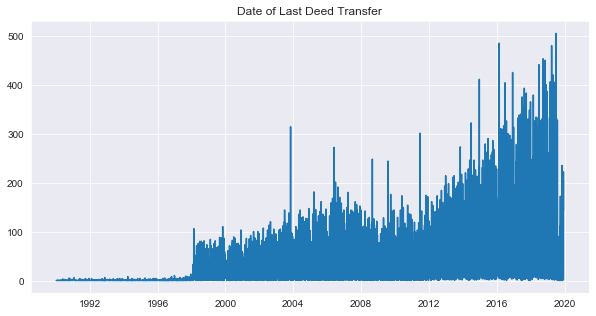

In [464]:
num_transfer = prop_df.deed_dt.value_counts().sort_index().loc['1990-01-01':,].count()
print("{} properties have had their deed transferred since 1990.".format(num_transfer))

# What is the distribution of the deed_dt in the dataset Bexar County
plt.figure(figsize=(10,5))
plt.plot(prop_df.deed_dt.value_counts().sort_index().loc['1990-01-01':,])
plt.title("Date of Last Deed Transfer")
plt.show()

### Different Ownership Types Across Labels

In [461]:
# Are these properties owned by companies or people?
print(prop_df[prop_df.crim_prop==1]['owner_legal_person'].value_counts())
print(prop_df[prop_df.crim_prop==1]['owner_likely_company'].value_counts())

1    39
0     9
Name: owner_legal_person, dtype: int64
1    41
0     7
Name: owner_likely_company, dtype: int64


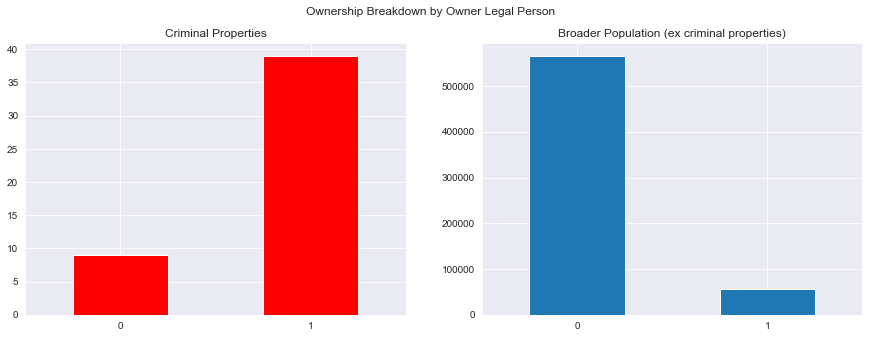

In [462]:
# Plot the breakdown between the two
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Ownership Breakdown by Owner Legal Person")
crim_sub_df.owner_legal_person.value_counts().sort_index().plot.bar(rot=0,ax=axes[0],title="Criminal Properties",color='red')
prop_df[prop_df.crim_prop!=1].owner_legal_person.value_counts().sort_index().plot.bar(rot=0,ax=axes[1],title="Broader Population (ex criminal properties)")
plt.show()

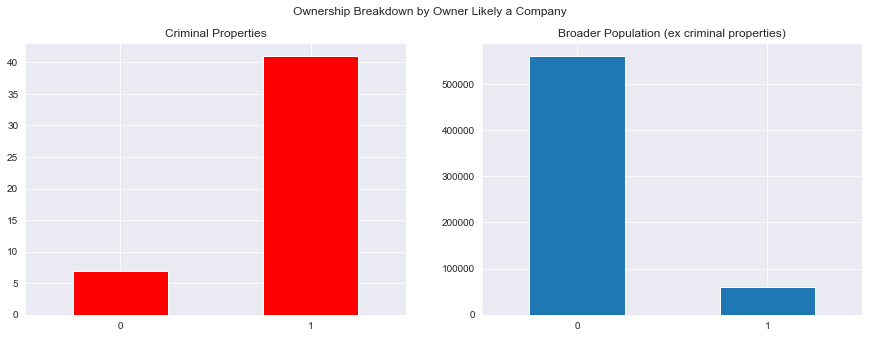

In [463]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Ownership Breakdown by Owner Likely a Company")
crim_sub_df.owner_likely_company.value_counts().sort_index().plot.bar(rot=0,ax=axes[0],title="Criminal Properties",color='red')
prop_df[prop_df.crim_prop!=1].owner_likely_company.value_counts().sort_index().plot.bar(rot=0,ax=axes[1],title="Broader Population (ex criminal properties)")
plt.show()

The broader population of residential properties are far more often owned by a natural person than a company. The opposite is true for those properties labeled as criminally-linked, matching a common typology for money-laundering in real property.

### Price PSF Across Different Ownership Types

Price psf for properties where the owner is a legal person:
                    describe                                                \
                       count        mean          std       min        25%   
owner_legal_person                                                           
0                   517598.0  105.582039    80.632885  0.086096  85.000000   
1                    37655.0  167.625694  1119.905659  0.019408  68.120467   

                                                           
                           50%         75%            max  
owner_legal_person                                         
0                   101.126372  118.791452   23736.939394  
1                    94.689737  131.588886  124520.000000   

Price psf for properties where the owner is likely a company:
                      describe                                               \
                         count        mean         std       min        25%   
owner_likely_company       

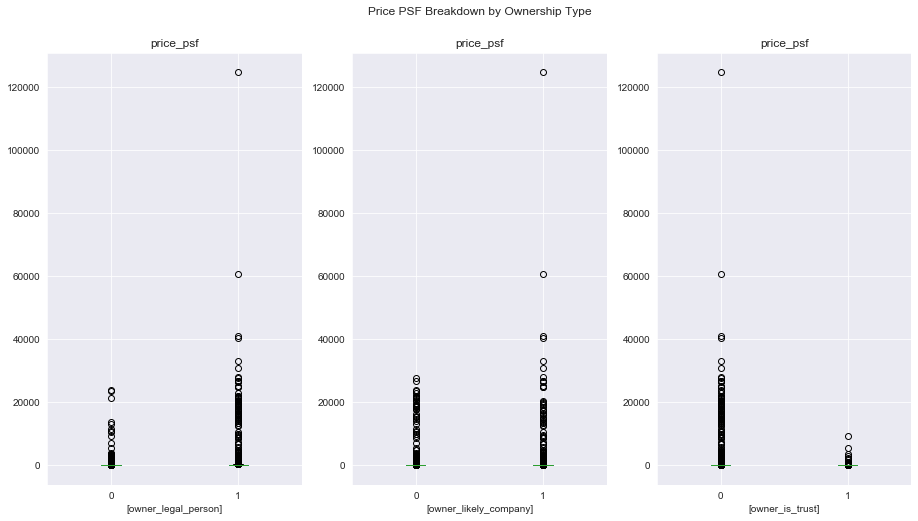

In [516]:
print("Price psf for properties where the owner is a legal person:")
print(prop_df.groupby('owner_legal_person')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is likely a company:")
print(prop_df.groupby('owner_likely_company')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is a trust:")
print(prop_df.groupby('owner_is_trust')['price_psf'].agg(['describe']))

groups = ['owner_legal_person','owner_likely_company','owner_is_trust']
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)

fig.suptitle("Price PSF Breakdown by Ownership Type")
plt.show()

For cases where the owner is coded as either a legal person, "likely a company," or trust, the mean price per square foot seems higher. However, the median price per square foot for the first two is lower than the median price where the owner is not a legal person or likely a company. This makes sense given the outliers visible in the boxplots.

Price psf for properties where the two measurable GTO requirements are met:
              describe                                                \
                 count        mean          std       min        25%   
two_gto_reqs                                                           
0             537208.0  105.865928   219.350421  0.019408  84.324169   
1              18045.0  226.598762  1168.178783  1.815750  76.923077   

                                                     
                     50%         75%            max  
two_gto_reqs                                         
0             100.628249  118.340935  124520.000000  
1             122.710623  204.723247   60486.315789   

Price psf for properties where the owner is foreign-based:
                     describe                                                \
                        count        mean         std        min        25%   
foreign_based_owner                                                       

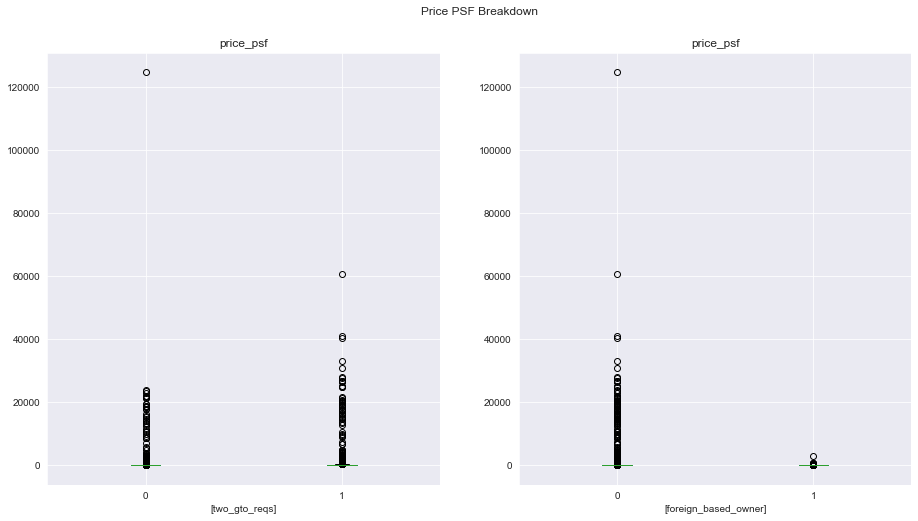

In [512]:
print("Price psf for properties where the two measurable GTO requirements are met:")
print(prop_df.groupby('two_gto_reqs')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is foreign-based:")
print(prop_df.groupby('foreign_based_owner')['price_psf'].agg(['describe']),'\n')

groups = ['two_gto_reqs','foreign_based_owner']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)

fig.suptitle("Price PSF Breakdown")
plt.show()

It seems the combination of the property being valued at more than $300,000 and owned by a company equals a higher average price per square foot. The owner being based outside of the United States, does not appear to be associated with that much of a difference in price per square foot.

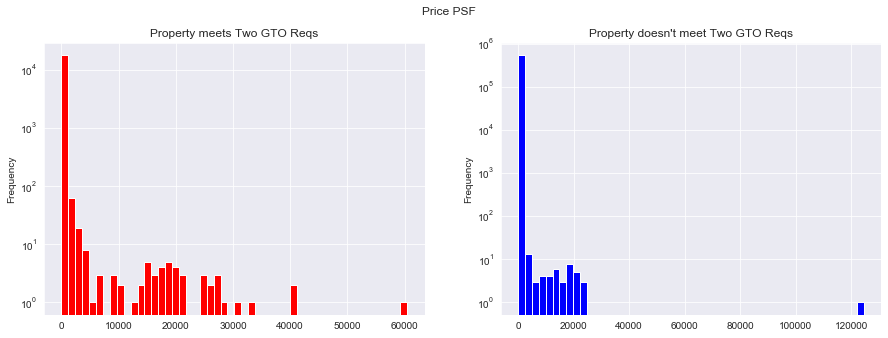

In [467]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Price PSF")
prop_df[prop_df['two_gto_reqs']==1].price_psf.dropna().plot(kind='hist',ax=axes[0],bins=50,
                                                            log=True,title='Property meets Two GTO Reqs',color='red')
prop_df[prop_df['two_gto_reqs']!=1].price_psf.dropna().plot(kind='hist',ax=axes[1],bins=50,
                                                            log=True,title='Property doesn\'t meet Two GTO Reqs',color='blue')
plt.show()

Similar to the above, there seems to be a wider range of prices per square foot when the property meets two of the FinCen GTO requirements.

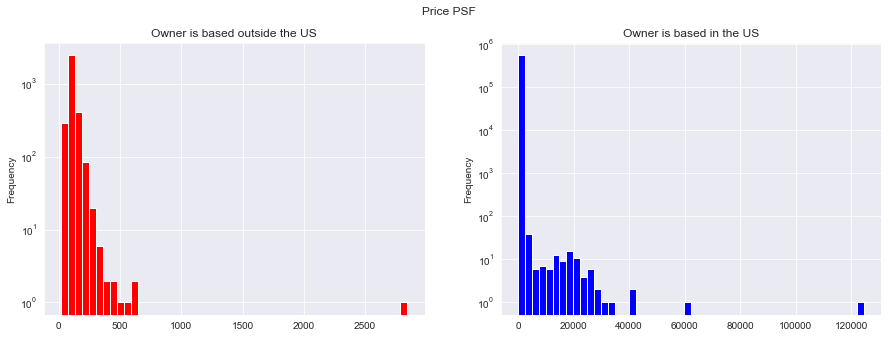

In [468]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Price PSF")
prop_df[prop_df['foreign_based_owner']==1].price_psf.dropna().plot(kind='hist',ax=axes[0],bins=50,
                                                                   log=True,title='Owner is based outside the US',
                                                                   color='red')
prop_df[prop_df['foreign_based_owner']!=1].price_psf.dropna().plot(kind='hist',ax=axes[1],bins=50,
                                                                   log=True,title='Owner is based in the US',
                                                                   color='blue')
plt.show()

### Just-Established Owner and Owner Owns Multiple Properties
Does a just-established owner pay a higher price psf? What about an owner that owns multiple properties?

Price psf for properties where the owner is just-established:
                        describe                                               \
                           count        mean         std       min        25%   
just_established_owner                                                          
0                       544189.0  108.620235  276.621413  0.019408  84.331984   
1                        11064.0  167.304833  904.321625  0.031926  77.597920   

                                                          
                               50%         75%       max  
just_established_owner                                    
0                       100.885461  119.043785  124520.0  
1                        99.025794  131.827767   40433.0   

Price psf for properties where the owner owns multiple properties:
                     describe                                               \
                        count        mean         std       min        25%   
owner_owns_m

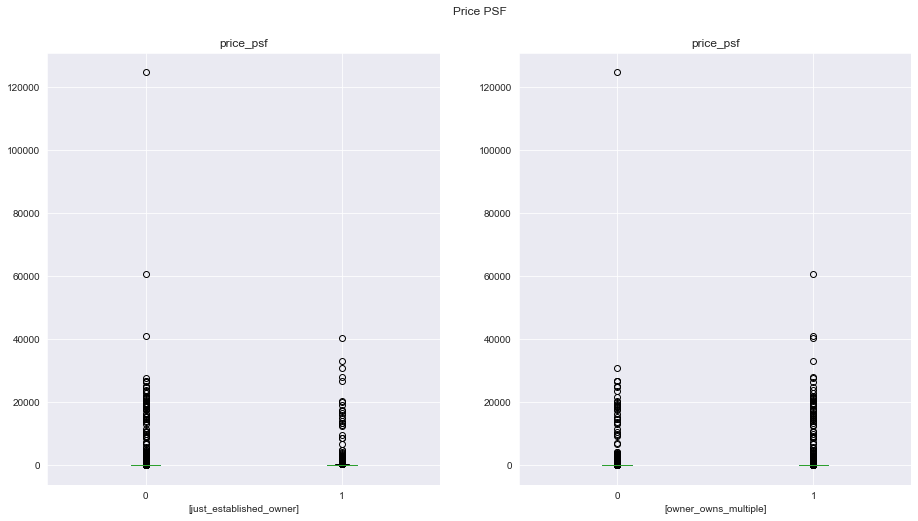

In [517]:
print("Price psf for properties where the owner is just-established:")
print(prop_df.groupby('just_established_owner')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner owns multiple properties:")
print(prop_df.groupby('owner_owns_multiple')['price_psf'].agg(['describe']),'\n')

groups = ['just_established_owner','owner_owns_multiple']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)
plt.suptitle('Price PSF')
plt.show()

While there are some outliers making the average higher, the median price per square for properties owned by companies established in the last 365 days is actually lower. It is a similar case for when the property owner owns multiple properties.

### Visualizing YoY Price Fluctuations

How do the fluctuations in price year-over-year differ between positively-labeled properties and the broader population?

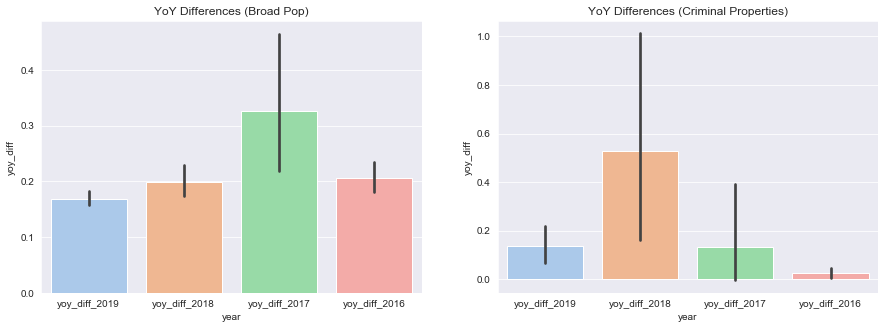

In [518]:
prop_melt = pd.melt(prop_df[prop_df.crim_prop!=1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()
crim_sub_melt = pd.melt(prop_df[prop_df.crim_prop==1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()

fig, axes = plt.subplots(1,2,figsize=[15,5])
sns.barplot(x='year',y='yoy_diff',data=prop_melt,palette='pastel',ax=axes[0]).set_title('YoY Differences (Broad Pop)')
sns.barplot(x='year',y='yoy_diff',data=crim_sub_melt,palette='pastel',ax=axes[1]).set_title('YoY Differences (Criminal Properties)')
plt.show()

### Missing Values

Identifying how many missing values there are per variable will allow meto to narrow down the list of variables that will be used in modeling.

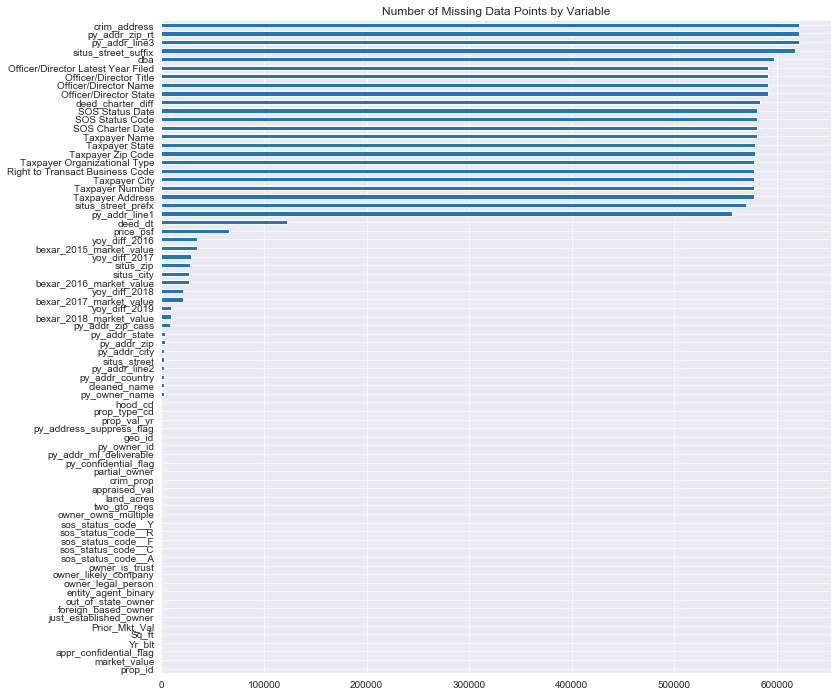

In [519]:
# How many missing values
ax = prop_df.isnull().sum().sort_values().plot.barh(figsize = [12,12])
ax.set_title('Number of Missing Data Points by Variable')
plt.show()

This is generally in line with what I was expecting. Most of the missing variables are from the companies data merge. Aside from py_addr_zip, the others will be dropped as features.

In [521]:
print('Price PSF nulls:')
print(prop_df.price_psf.isnull().sum(),'\n')
print('YoY Diff 2016 nulls:')
print(prop_df.yoy_diff_2016.isnull().sum(),'\n')

Price PSF nulls:
66232 

YoY Diff 2016 nulls:
34988 



### Correlation Matrix

In [472]:
# Setting the number of acceptable NaN values to 70,000 to be sure to include Price PSF as a feature
nan_limit = 70000
check_nan = prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(prop_df.columns[prop_df.dtypes!='object'])]
variables_list = variables_list.drop(['prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
                                     'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
                                      'bexar_2017_market_value','bexar_2018_market_value'])

print(variables_list)

Index(['partial_owner', 'py_addr_zip', 'py_confidential_flag',
       'py_address_suppress_flag', 'py_addr_ml_deliverable', 'situs_zip',
       'hood_cd', 'land_acres', 'market_value', 'appr_confidential_flag',
       'Yr_blt', 'Sq_ft', 'just_established_owner', 'foreign_based_owner',
       'yoy_diff_2019', 'yoy_diff_2018', 'yoy_diff_2017', 'yoy_diff_2016',
       'out_of_state_owner', 'entity_agent_binary', 'owner_legal_person',
       'owner_likely_company', 'owner_is_trust', 'sos_status_code__A',
       'sos_status_code__C', 'sos_status_code__F', 'sos_status_code__R',
       'sos_status_code__Y', 'owner_owns_multiple', 'price_psf',
       'two_gto_reqs', 'crim_prop'],
      dtype='object')


In [473]:
prop_df[variables_list].head(10)

,partial_owner,py_addr_zip,py_confidential_flag,py_address_suppress_flag,py_addr_ml_deliverable,situs_zip,hood_cd,land_acres,market_value,appr_confidential_flag,...,owner_is_trust,sos_status_code__A,sos_status_code__C,sos_status_code__F,sos_status_code__R,sos_status_code__Y,owner_owns_multiple,price_psf,two_gto_reqs,crim_prop
0,0,78212.0,0,0,1,78212,10330,11870,587780,0,...,0,1,0,0,0,0,1,181.245760,1,0.0
1,0,78212.0,0,0,1,78212,57027,2640,300000,0,...,0,0,0,0,0,0,0,110.213079,0,0.0
2,0,77406.0,0,0,1,78212,57027,2041,165000,0,...,0,0,0,0,0,0,1,165.995976,0,0.0
3,0,77406.0,0,0,1,78212,57027,1388,154630,0,...,0,0,0,0,0,0,1,78.572154,0,0.0
4,0,78283.0,0,0,1,78212,10480,2221,203180,0,...,0,0,0,0,0,0,1,NaN,0,0.0
5,0,78212.0,0,0,1,78212,10330,6033,192110,0,...,0,1,0,0,0,0,1,NaN,0,0.0
6,0,78212.0,0,0,1,78212,10480,3649,336580,0,...,0,0,0,0,0,0,0,73.169565,1,0.0
7,0,78213.0,0,0,0,78212,10480,5152,488410,0,...,0,0,0,0,0,0,0,42.470435,1,0.0
8,0,78212.0,0,0,1,78212,57032,3000,205000,0,...,0,0,0,0,0,0,1,243.467933,0,0.0
9,0,78212.0,0,0,1,78212,57032,6001,444300,0,...,0,0,0,0,0,0,0,149.445005,0,0.0


In [475]:
# Pull out variables and plot correlation matrix
sub_df = prop_df[variables_list]
print(len(variables_list))
sub_df.corr()

32


,partial_owner,py_confidential_flag,py_address_suppress_flag,py_addr_ml_deliverable,land_acres,market_value,appr_confidential_flag,Yr_blt,Sq_ft,just_established_owner,...,owner_is_trust,sos_status_code__A,sos_status_code__C,sos_status_code__F,sos_status_code__R,sos_status_code__Y,owner_owns_multiple,price_psf,two_gto_reqs,crim_prop
partial_owner,1.000000,-0.002885,-0.003674,0.020505,0.056591,-0.015836,-0.002881,0.006886,-0.006270,-0.008815,...,-0.004246,-0.014186,-0.000170,-0.000723,-0.004540,-0.000108,-0.021962,-0.012072,-0.011239,-0.000528
py_confidential_flag,-0.002885,1.000000,0.793680,0.025877,-0.001822,0.000135,0.990210,0.016330,-0.000738,-0.010048,...,-0.008271,-0.015684,-0.000177,-0.000751,-0.004717,-0.000112,0.134522,0.000854,-0.010981,-0.000549
py_address_suppress_flag,-0.003674,0.793680,1.000000,0.032503,-0.001679,0.004307,0.785865,0.016463,-0.000126,-0.010249,...,-0.001664,-0.016200,-0.000222,-0.000943,-0.003175,-0.000141,0.113369,0.001924,-0.011356,-0.000689
py_addr_ml_deliverable,0.020505,0.025877,0.032503,1.000000,-0.005086,0.035825,0.025777,0.009948,0.020621,0.056402,...,0.040565,0.074411,0.001183,0.000123,0.022763,0.000748,0.039132,0.007221,0.023569,0.003664
land_acres,0.056591,-0.001822,-0.001679,-0.005086,1.000000,0.142863,-0.001826,-0.101699,0.028139,0.032073,...,0.006754,0.036422,-0.000063,0.001948,0.017163,0.000289,0.063367,0.093377,0.093704,0.001302
market_value,-0.015836,0.000135,0.004307,0.035825,0.142863,1.000000,0.000054,0.060035,0.787742,0.184810,...,0.014968,0.170391,0.015699,0.025630,0.028939,0.016515,0.034808,0.054872,0.495916,0.009252
appr_confidential_flag,-0.002881,0.990210,0.785865,0.025777,-0.001826,0.000054,1.000000,0.015793,-0.000803,-0.010038,...,-0.008064,-0.015010,-0.000177,-0.000750,-0.004712,-0.000112,0.133771,0.000839,-0.010826,-0.000548
Yr_blt,0.006886,0.016330,0.016463,0.009948,-0.101699,0.060035,0.015793,1.000000,0.103890,-0.098339,...,0.009514,-0.238916,-0.000813,-0.007342,-0.055368,0.000639,-0.438509,-0.321017,-0.034939,-0.005008
Sq_ft,-0.006270,-0.000738,-0.000126,0.020621,0.028139,0.787742,-0.000803,0.103890,1.000000,0.141822,...,0.006183,0.123375,0.007540,0.015950,0.025946,0.010076,0.011153,-0.005350,0.382990,0.004689
just_established_owner,-0.008815,-0.010048,-0.010249,0.056402,0.032073,0.184810,-0.010038,-0.098339,0.141822,1.000000,...,-0.020860,0.594554,0.014004,0.044932,0.124712,0.005427,0.223179,0.027133,0.305449,0.014921


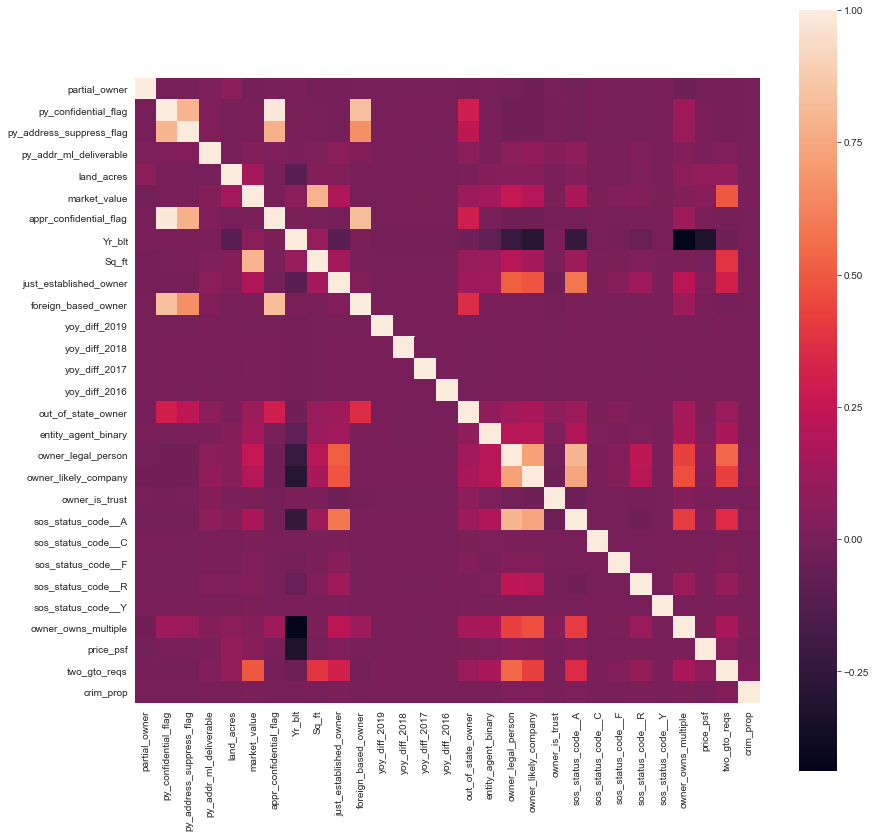

In [452]:
plt.figure(figsize=(14,14))
sns.heatmap(sub_df.corr(),vmax=1,square=True)
plt.show()

Observations:
- High correlation amongst the "confidential flag" variables, which makes sense. 
- Negative correlation between the year the property was built and price per square foot; this also makes intuitive sense. 
- It is interesting that there is also a negative correlation between the owner likely being a company and the year the property was built as well as the owner owning multiple properties.
- Does not seem to be much correlation between the criminal property label and the other variables